# Setup
This IPython notebook will walk through the steps of characterizing iModulons through the semi-automated tools in PyModulon. You will need:

* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

Optional:
* iModulon table (if you already have some characterized iModulons)

In [1]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [2]:
# Enter the location of your data here
data_dir = path.join('..','data','5g_processed_data')
ica_data_dir = path.join('..','data','reICA_lowExAdj')

# GO and KEGG annotations are in the 'external' folder
external_data = path.join('..','data','external')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'final_meta.tsv'),sep='\t')
df_metadata.head()

,sample_id,exp_theme,exp_condition,sample,shortd,longd,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,include?,notes,cluster_id,project,condition,reference_condition,xorder
0,5GB1_FM03_TR1_QC_tpm,uMax,uMax,5GB1_FM03_TR1_QC,uMax_QC,"Fermentor run 3, uMax though close to O2 limit...",2,1,0,3,0,2,0,1,NaN,1,5G,uMax,uMax,uMax
1,5GB1_FM20_TR3_tpm,uMax,uMax,5GB1_FM20_TR3,uMax,"Fermentor run 20, uMax",2,1,0,3,0,2,0,1,NaN,9,5G,uMax,uMax,uMax
2,5GB1_FM20_TR3_QC_tpm,uMax,uMax,5GB1_FM20_TR3_QC,uMax_QC,"Fermentor run 20, uMax, QC",2,1,0,3,0,2,0,1,NaN,4,5G,uMax,uMax,uMax
3,5GB1_FM20_TR3_UW_tpm,uMax,uMax,5GB1_FM20_TR3_UW,uMax,"Fermentor run 20, uMax",2,1,0,3,0,2,0,1,NaN,10,5G,uMax,uMax,uMax
4,5GB1_FM20_TR2_QC_tpm,uMax,uMax,5GB1_FM20_TR2_QC,uMax_QC,"Fermentor run 20, uMax",2,1,0,3,0,2,0,1,NaN,3,5G,uMax,uMax,uMax


In [4]:
df_metadata.columns

Index(['sample_id', 'exp_theme', 'exp_condition', 'sample', 'shortd', 'longd',
       'carbon_source', 'oxygen_level', 'nitrate_level', 'copper_level',
       'lanthanum_level', 'growth_rate', 'growth_mode', 'include?', 'notes',
       'cluster_id', 'project', 'condition', 'reference_condition', 'xorder'],
      dtype='object')

In [5]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## ~Check your TRN~ - We have no TRN for 5G!

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [6]:
# df_trn = pd.read_csv(path.join(external_data,'TRN.csv'))
# df_trn.head()

In [7]:
#df_trn[df_trn['regulator'] == 'AbrB']

The `regulator` and `gene_id` must be filled in for each row

In [8]:
# print(df_trn.regulator.notnull().all())
# print(df_trn.gene_id.notnull().all())

## Load the data
You're now ready to load your IcaData object!

In [9]:
m = pd.read_csv(path.join(ica_data_dir,'M.csv'))
m.head()

,locus_tag,0,1,2,3,4,5,6,7,8,...,39,40,41,42,43,44,45,46,47,48
0,EQU24_RS00005,0.008106,0.005958,-0.000973,0.005020,-0.000902,-0.000786,-0.000232,0.000464,0.000613,...,0.017648,0.003639,-0.008772,-0.002863,0.010215,0.017158,-0.000338,-0.003260,-0.003292,-0.008184
1,EQU24_RS00010,-0.008048,0.007115,-0.007302,-0.010286,-0.001014,-0.012079,-0.005382,0.005949,-0.009360,...,0.002159,0.022228,-0.006319,-0.001443,0.002313,0.013262,0.004313,0.008151,-0.000594,-0.000613
2,EQU24_RS00015,-0.009157,-0.006115,0.000257,0.003737,0.004103,-0.010172,-0.006457,-0.011451,0.001256,...,0.013601,0.003763,-0.004342,0.010746,-0.008276,-0.012718,0.006972,0.012166,0.000173,-0.010324
3,EQU24_RS00020,0.001317,0.006972,0.001790,-0.004921,0.005381,-0.011949,-0.000320,0.006669,0.010065,...,-0.007723,0.008731,-0.001293,0.004018,-0.002160,0.001267,-0.001360,0.003109,0.001564,-0.001845
4,EQU24_RS00025,-0.004423,0.002516,-0.020823,0.006917,-0.012681,0.020570,-0.007285,-0.007771,0.008207,...,-0.005849,-0.006510,-0.003951,0.005511,0.023397,0.000842,-0.005736,0.006981,0.024343,0.003234


In [10]:
a = pd.read_csv(path.join(ica_data_dir,'A.csv'))
a.head()

,Unnamed: 0,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,5GB1_FM14_TR1_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,0,5.392400,4.919376,7.199995,4.747709,9.049532,9.552191,9.573690,9.575747,5.010335,...,-5.722179,-4.365542,1.087840,-0.295770,-2.118158,0.357941,1.132178,-0.913844,-1.623915,-0.954438
1,1,-2.185597,-1.022851,0.316660,1.198517,4.495507,3.904569,4.068092,4.531462,6.733576,...,6.512657,5.921157,14.286606,13.398541,13.377855,10.642424,14.756586,14.247071,13.819355,11.891567
2,2,-4.736416,-5.547870,-3.381343,-4.102584,-0.214375,0.022046,-0.058911,3.000460,-3.476842,...,1.752800,3.429500,1.415952,1.479412,2.725678,1.748855,0.744416,1.716110,2.372845,2.950108
3,3,-5.627296,-1.111183,-25.930870,2.171677,0.567868,0.345844,0.774512,-0.660152,1.436831,...,1.759825,1.179319,2.197590,2.043483,3.158511,2.402069,2.229670,3.028928,3.529424,0.939422
4,4,-5.721233,-6.813364,2.619158,1.373166,2.310599,3.182505,2.094377,2.327430,3.029428,...,2.648217,3.552848,3.036290,3.800305,2.077334,4.104200,2.749641,3.518375,2.946372,3.655318


In [12]:
x = pd.read_csv(path.join(data_dir,'log_norm_uMax_indiv_lowExAdj_15.csv'))
x.head()

,locus_tag,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,5GB1_FM14_TR1_tpm,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,-0.081618,0.013543,-1.005473,-0.565908,-0.868240,-0.861181,-0.860286,-0.810841,-0.466774,...,-0.423331,-0.413887,-0.465584,-0.361508,-0.366746,-0.629039,-0.374679,-0.430905,-0.773416,-0.326023
1,EQU24_RS00010,-0.213951,-0.115316,-0.677320,-0.569877,-1.119576,-1.054664,-1.167149,-1.149678,-0.423026,...,-0.179590,-0.182090,-0.479849,-0.274384,-0.346861,-0.306024,-0.388553,-0.356148,-0.679766,-0.170025
2,EQU24_RS00015,0.002850,-0.174656,-0.639651,-0.279816,-1.029608,-1.120098,-1.028006,-0.996256,-0.586234,...,-0.110156,0.045097,-0.655508,-0.483245,-0.609796,-0.620538,-0.578460,-0.572416,-0.801799,-0.181680
3,EQU24_RS00020,-0.130356,0.040745,-0.414605,-0.346534,-0.941858,-0.957353,-0.913985,-0.980052,-0.512366,...,0.082403,0.193677,-0.363136,-0.123069,-0.244925,-0.128927,-0.032470,-0.106898,-0.295688,-0.049523
4,EQU24_RS00025,0.659048,0.404700,-0.031390,0.291903,-0.787794,-0.640604,-0.818610,-0.839456,-0.307450,...,0.087352,0.059120,-0.455537,-0.375085,-0.325837,-0.267183,-0.280655,-0.400990,-0.192058,-0.235679


In [15]:
s = pd.read_csv(path.join(data_dir,'final_meta.tsv'),sep='\t',index_col=0)
s

,exp_theme,exp_condition,sample,shortd,longd,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,include?,notes,cluster_id,project,condition,reference_condition,xorder
sample_id,,,,,,,,,,,,,,,,,,,
5GB1_FM03_TR1_QC_tpm,uMax,uMax,5GB1_FM03_TR1_QC,uMax_QC,"Fermentor run 3, uMax though close to O2 limit...",2,1,0,3,0,2,0,1,NaN,1,5G,uMax,uMax,uMax
5GB1_FM20_TR3_tpm,uMax,uMax,5GB1_FM20_TR3,uMax,"Fermentor run 20, uMax",2,1,0,3,0,2,0,1,NaN,9,5G,uMax,uMax,uMax
5GB1_FM20_TR3_QC_tpm,uMax,uMax,5GB1_FM20_TR3_QC,uMax_QC,"Fermentor run 20, uMax, QC",2,1,0,3,0,2,0,1,NaN,4,5G,uMax,uMax,uMax
5GB1_FM20_TR3_UW_tpm,uMax,uMax,5GB1_FM20_TR3_UW,uMax,"Fermentor run 20, uMax",2,1,0,3,0,2,0,1,NaN,10,5G,uMax,uMax,uMax
5GB1_FM20_TR2_QC_tpm,uMax,uMax,5GB1_FM20_TR2_QC,uMax_QC,"Fermentor run 20, uMax",2,1,0,3,0,2,0,1,NaN,3,5G,uMax,uMax,uMax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1_LTrecycle_TR1_QC_tpm,LanzaTech,LanzaTech,5GB1_LTrecycle_TR1_QC,LTrecycle_QC,LanzaTech Cell recycle,-1,-1,-1,-1,-1,-1,-1,1,other exp,18,5G,LanzaTech,uMax,NaN
5GB1_FM_85_TR1_tpm,aa3_KO,aa3_KO,5GB1_FM_85_TR1,5GB1_FM_85,Fermentor run 85,2,1,0,3,0,2,0,1,other exp,14,5G,aa3_KO,uMax,NaN
5GB1_FM_85_TR2_tpm,aa3_KO,aa3_KO,5GB1_FM_85_TR2,5GB1_FM_85,Fermentor run 85,2,1,0,3,0,2,0,1,other exp,14,5G,aa3_KO,uMax,NaN


In [16]:
g = pd.read_csv(path.join(data_dir,'5G_gene_info3.csv'))
g.tail()

,locus_tag,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,uniprot,tu_id,tu_name,ncbi_protein,gene_name_extra
4208,EQU24_RS22135,mnmE,4994941,4996288,-1,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,J,"Translation, ribosomal structure and biogenesis",A0A4P9USW8,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841475.1,mnmE||mnmE
4209,EQU24_RS22140,yidC,4996295,4997993,-1,membrane protein insertase YidC,U,"Intracellular trafficking, secretion, and vesi...",A0A4V1IKE6,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841474.1,yidC||yidC
4210,EQU24_RS22145,yidD,4997998,4998220,-1,membrane protein insertion efficiency factor YidD,S,Function unknown,UPI000A004C04,1,rpmH // rnpA // yidD // yidC // mnmE,WP_083877753.1,yidD||yidD
4211,EQU24_RS22150,rnpA,4998201,4998570,-1,ribonuclease P protein component,J,"Translation, ribosomal structure and biogenesis",A0A4P9UT31,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841473.1,rnpA||rnpA
4212,EQU24_RS22155,rpmH,4998574,4998709,-1,50S ribosomal protein L34,J,"Translation, ribosomal structure and biogenesis",UPI00034B9E08,1,rpmH // rnpA // yidD // yidC // mnmE,WP_083877752.1,rpmH||rpmH


In [14]:
# ERIN: change this to the new M and A?
# ica_data = IcaData(M = path.join(ica_data_dir,'M.csv'),
#                    A = path.join(ica_data_dir,'A.csv'),
#                    X = path.join(data_dir,'5g_log_tpm_norm_indiv.csv'),
#                    gene_table = path.join(data_dir,'5G_gene_info2.csv'),
#                    sample_table = path.join(data_dir,'final_meta.tsv'),
#                    #trn = path.join(external_data,'TRN.csv'),
#                    optimize_cutoff=True)

If you don't have a TRN (or have a very minimal TRN), use `threshold_method = 'kmeans'`

In [17]:
# ERIN: ah, I'll use this version for 5g? bc no TRN

ica_data = IcaData(M = path.join(ica_data_dir,'M.csv'),
                   A = path.join(ica_data_dir,'A.csv'),
                   #X = path.join(data_dir,'5g_log_tpm_norm_indiv.csv'),
                   X = path.join(data_dir,'log_norm_uMax_indiv_lowExAdj_15.csv'),
                   gene_table = path.join(data_dir,'5G_gene_info3.csv'),
                   sample_table = path.join(data_dir,'final_meta.tsv'),
                   #trn = path.join(data_dir,'TRN.csv'),
                   threshold_method = 'kmeans')

In [18]:
ica_data.gene_table[ica_data.gene_table.index == "EQU24_RS18140"]

,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,uniprot,tu_id,tu_name,ncbi_protein,gene_name_extra
EQU24_RS18140,moxF,4043061,4044870,-1,"PQQ-dependent dehydrogenase, methanol/ethanol ...",G,Carbohydrate transport and metabolism,A0A4P9URC6,542,EQU24_RS18140,WP_017842205.1,||None


# ~Regulatory iModulons~ I don't have TRN, so skip this
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.

In [19]:
#ica_data.compute_trn_enrichment()

You can also search for AND/OR combinations of regulators using the `max_regs` argument.

Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table.

In [20]:
# First search for regulator enrichments with 2 regulators
# ica_data.compute_trn_enrichment(max_regs=2,save=True)

# # Next, search for regulator enrichments with just one regulator. This will supercede the 2 regulator enrichments.
# ica_data.compute_trn_enrichment(max_regs=1,save=True)

The list of regulatory iModulons are shown below

In [21]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
# print(len(ica_data.imodulon_table),'Total iModulons')
# print(len(regulatory_imodulons),'Regulatory iModulons')
# regulatory_imodulons

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

If two iModulons have the same regulator (e.g. 'Reg'), they will be named 'Reg-1' and 'Reg-2'

In [22]:
# ica_data.rename_imodulons(regulatory_imodulons.regulator.to_dict())
# ica_data.imodulon_table.head()

In [23]:
# regulatory_imodulons = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]

# Functional iModulons

GO annotations and KEGG pathways/modules were generated in the 1_create_the_gene_table.ipynb notebook. Enrichments will be calculated in this notebook, and further curated in the 3_manual_iModulon_curation notebook.

## GO Enrichments

First load the Gene Ontology annotations

In [24]:
#DF_GO = pd.read_csv(path.join(external_data,'5G_GO_annotations_from_egg.csv'),index_col=0)
DF_GO = pd.read_csv(path.join(external_data,'5G_go_combined_melt.tsv'),sep='\t').fillna("")
print(DF_GO.shape)
DF_GO.head()

(64545, 3)


,locus_tag,go_id,go_name
0,EQU24_RS00005,GO:0000166,nucleotide binding
1,EQU24_RS00005,GO:2000112,regulation of cellular macromolecule biosynthe...
2,EQU24_RS00005,GO:1990837,sequence-specific double-stranded DNA binding
3,EQU24_RS00005,GO:0003677,DNA binding
4,EQU24_RS00005,GO:0008144,


In [25]:
# i think IcaData object needs 'gene_id' column
DF_GO['gene_id'] = DF_GO['locus_tag']
DF_GO.head(15)

,locus_tag,go_id,go_name,gene_id
0,EQU24_RS00005,GO:0000166,nucleotide binding,EQU24_RS00005
1,EQU24_RS00005,GO:2000112,regulation of cellular macromolecule biosynthe...,EQU24_RS00005
2,EQU24_RS00005,GO:1990837,sequence-specific double-stranded DNA binding,EQU24_RS00005
3,EQU24_RS00005,GO:0003677,DNA binding,EQU24_RS00005
4,EQU24_RS00005,GO:0008144,,EQU24_RS00005
5,EQU24_RS00005,GO:0006725,cellular aromatic compound metabolic process,EQU24_RS00005
6,EQU24_RS00005,GO:0080090,regulation of primary metabolic process,EQU24_RS00005
7,EQU24_RS00005,GO:0008152,metabolic process,EQU24_RS00005
8,EQU24_RS00005,GO:0009987,cellular process,EQU24_RS00005
9,EQU24_RS00005,GO:0043170,macromolecule metabolic process,EQU24_RS00005


In [26]:
# add the top 5 go annotations to the ica_data.gene_table
ica_data.gene_table

,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,uniprot,tu_id,tu_name,ncbi_protein,gene_name_extra
EQU24_RS00005,dnaA,0,1317,1,chromosomal replication initiator protein DnaA,L,"Replication, recombination and repair",A0A4P9UMW3,2831,dnaA,WP_017841472.1,dnaA||dnaA
EQU24_RS00010,NaN,1502,2603,1,DNA polymerase III subunit beta,L,"Replication, recombination and repair",A0A4P9UIN3,2830,EQU24_RS00010,WP_017841471.1,||dnaN
EQU24_RS00015,recF,3060,4140,1,DNA replication/repair protein RecF,L,"Replication, recombination and repair",A0A4P9UIH3,2829,recF,WP_017841470.1,recF||recF
EQU24_RS00020,gyrB,4185,6600,1,DNA topoisomerase (ATP-hydrolyzing) subunit B,L,"Replication, recombination and repair",A0A4P9UI83,2828,gyrB,WP_017841469.1,gyrB||gyrB
EQU24_RS00025,NaN,6825,7062,1,hypothetical protein,X,No COG annotation,NaN,2827,EQU24_RS00030 // EQU24_RS00025,NaN,||
...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,mnmE,4994941,4996288,-1,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,J,"Translation, ribosomal structure and biogenesis",A0A4P9USW8,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841475.1,mnmE||mnmE
EQU24_RS22140,yidC,4996295,4997993,-1,membrane protein insertase YidC,U,"Intracellular trafficking, secretion, and vesi...",A0A4V1IKE6,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841474.1,yidC||yidC
EQU24_RS22145,yidD,4997998,4998220,-1,membrane protein insertion efficiency factor YidD,S,Function unknown,UPI000A004C04,1,rpmH // rnpA // yidD // yidC // mnmE,WP_083877753.1,yidD||yidD
EQU24_RS22150,rnpA,4998201,4998570,-1,ribonuclease P protein component,J,"Translation, ribosomal structure and biogenesis",A0A4P9UT31,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841473.1,rnpA||rnpA


In [27]:
from goatools import obo_parser
go_file = os.path.join('..','data','external','GO_20220505.txt')
p = obo_parser.GODag(go_file)

../data/external/GO_20220505.txt: fmt(1.2) rel(2022-03-22) 47,103 Terms


In [28]:
def get_top_k_gos(gene_table, k):
    '''
    Given a table of genes, get the top k most specific GO terms
    '''
    def get_go_level(go_id):
        try:
            return p[go_id].level
        except:
            return -1 # not in go dag

    DF_GO['go_level'] = DF_GO['go_id'].apply(lambda x: get_go_level(x))

    # loop through genes in gene table to get top k go term names
    loc2top_gos = {}
    for _,row in gene_table.iterrows():
        locus_tag = row.name
        gene_gos = DF_GO[DF_GO['locus_tag']==locus_tag].sort_values('go_level',ascending=False).head(k)
        go_terms = gene_gos['go_name'].values
        loc2top_gos[locus_tag] = go_terms

    # add gos to gene table
    #gene_table['specific_gos'] = gene_table.reset_index()['index'].apply(lambda x: loc2top_gos[x])
    return loc2top_gos
    

        

In [29]:
top5gos = get_top_k_gos(ica_data.gene_table, 5)

In [30]:
DF_GO[DF_GO['locus_tag']=='EQU24_RS05905'].sort_values('go_level',ascending=False).head(5)

,locus_tag,go_id,go_name,gene_id,go_level
21929,EQU24_RS05905,GO:0015049,methane monooxygenase activity,EQU24_RS05905,5
21940,EQU24_RS05905,GO:0015050,methane monooxygenase complex,EQU24_RS05905,4
21933,EQU24_RS05905,GO:0016709,"oxidoreductase activity, acting on paired dono...",EQU24_RS05905,4
21927,EQU24_RS05905,GO:0015947,methane metabolic process,EQU24_RS05905,4
21937,EQU24_RS05905,GO:0016705,"oxidoreductase activity, acting on paired dono...",EQU24_RS05905,3


In [31]:
'\n'.join(list(top5gos['EQU24_RS00005']))

'DNA replication origin binding\nsequence-specific double-stranded DNA binding\nregulation of cellular macromolecule biosynthetic process\nDNA-templated DNA replication\nregulation of DNA replication'

In [32]:
ica_data.gene_table['specific_gos_n'] = ica_data.gene_table.apply(lambda row: '\n'.join(top5gos[row.name]),axis=1)
ica_data.gene_table['specific_gos'] = ica_data.gene_table.apply(lambda row: top5gos[row.name],axis=1)

In [33]:
ica_data.gene_table.reset_index()

,index,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,uniprot,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
0,EQU24_RS00005,dnaA,0,1317,1,chromosomal replication initiator protein DnaA,L,"Replication, recombination and repair",A0A4P9UMW3,2831,dnaA,WP_017841472.1,dnaA||dnaA,DNA replication origin binding\nsequence-speci...,"[DNA replication origin binding, sequence-spec..."
1,EQU24_RS00010,NaN,1502,2603,1,DNA polymerase III subunit beta,L,"Replication, recombination and repair",A0A4P9UIN3,2830,EQU24_RS00010,WP_017841471.1,||dnaN,DNA strand elongation involved in DNA replicat...,[DNA strand elongation involved in DNA replica...
2,EQU24_RS00015,recF,3060,4140,1,DNA replication/repair protein RecF,L,"Replication, recombination and repair",A0A4P9UIH3,2829,recF,WP_017841470.1,recF||recF,DNA synthesis involved in DNA repair\ndouble-s...,"[DNA synthesis involved in DNA repair, double-..."
3,EQU24_RS00020,gyrB,4185,6600,1,DNA topoisomerase (ATP-hydrolyzing) subunit B,L,"Replication, recombination and repair",A0A4P9UI83,2828,gyrB,WP_017841469.1,gyrB||gyrB,ATP hydrolysis activity\nATP hydrolysis activi...,"[ATP hydrolysis activity, ATP hydrolysis activ..."
4,EQU24_RS00025,NaN,6825,7062,1,hypothetical protein,X,No COG annotation,NaN,2827,EQU24_RS00030 // EQU24_RS00025,NaN,||,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,EQU24_RS22135,mnmE,4994941,4996288,-1,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,J,"Translation, ribosomal structure and biogenesis",A0A4P9USW8,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841475.1,mnmE||mnmE,tRNA wobble uridine modification\ntRNA process...,"[tRNA wobble uridine modification, tRNA proces..."
4209,EQU24_RS22140,yidC,4996295,4997993,-1,membrane protein insertase YidC,U,"Intracellular trafficking, secretion, and vesi...",A0A4V1IKE6,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841474.1,yidC||yidC,protein homooligomerization\nprotein complex o...,"[protein homooligomerization, protein complex ..."
4210,EQU24_RS22145,yidD,4997998,4998220,-1,membrane protein insertion efficiency factor YidD,S,Function unknown,UPI000A004C04,1,rpmH // rnpA // yidD // yidC // mnmE,WP_083877753.1,yidD||yidD,amide transport\nprotein insertion into membra...,"[amide transport, protein insertion into membr..."
4211,EQU24_RS22150,rnpA,4998201,4998570,-1,ribonuclease P protein component,J,"Translation, ribosomal structure and biogenesis",A0A4P9UT31,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841473.1,rnpA||rnpA,tRNA 5'-leader removal\ntRNA 3'-end processing...,"[tRNA 5'-leader removal, tRNA 3'-end processin..."


In [34]:
# calculate GO enrichment
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'go_name')

In [35]:
DF_GO_enrich

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,0,transposase activity,2.420907e-09,8.672263e-06,0.082474,0.280702,0.127490,16.0,57.0,194.0
1,0,"transposition, DNA-mediated",4.227279e-09,8.672263e-06,0.082474,0.271186,0.126482,16.0,59.0,194.0
2,0,RNA-directed DNA polymerase activity,2.291670e-07,2.350681e-04,0.030928,0.750000,0.059406,6.0,8.0,194.0
3,0,RNA-templated DNA biosynthetic process,2.291670e-07,2.350681e-04,0.030928,0.750000,0.059406,6.0,8.0,194.0
4,1,bacterial-type flagellum-dependent cell motility,3.959071e-11,1.624407e-07,0.128205,0.344828,0.186916,10.0,29.0,78.0
...,...,...,...,...,...,...,...,...,...,...
355,40,biological regulation,4.027804e-03,8.756937e-02,0.077640,0.132979,0.098039,25.0,188.0,322.0
356,40,chaperone-mediated protein folding,4.000591e-03,8.756937e-02,0.015528,0.333333,0.029674,5.0,15.0,322.0
357,40,protein localization,4.033783e-03,8.756937e-02,0.024845,0.228571,0.044818,8.0,35.0,322.0
358,40,peptide transport,4.150732e-03,8.916467e-02,0.021739,0.250000,0.040000,7.0,28.0,322.0


In [41]:
#old
DF_GO_enrich['imodulon'].value_counts()

41    249
9     105
39     48
27     10
32      7
36      4
15      3
22      3
6       2
8       2
17      2
29      2
31      2
2       1
10      1
Name: imodulon, dtype: int64

In [36]:
#new
DF_GO_enrich['imodulon'].value_counts()

40    191
15    115
1      10
26     10
19      7
39      6
0       4
33      4
17      3
6       2
18      2
35      2
8       1
29      1
31      1
37      1
Name: imodulon, dtype: int64

In [53]:
DF_GO_enrich[DF_GO_enrich['imodulon'] == 37]

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
162,37,cobalamin biosynthetic process,2.226000e-12,9.133277e-09,0.095238,0.555556,0.162602,10.0,18.0,105.0


In [54]:
DF_GO_enrich.sort_values('pvalue')#.head()

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
169,40,cytosolic ribosome,4.927472e-38,1.010871e-34,0.133540,0.767857,0.227513,43.0,56.0,322.0
170,40,ribosomal subunit,4.927472e-38,1.010871e-34,0.133540,0.767857,0.227513,43.0,56.0,322.0
172,40,peptide biosynthetic process,1.395994e-37,1.458916e-34,0.170807,0.567010,0.262530,55.0,97.0,322.0
171,40,structural constituent of ribosome,1.422292e-37,1.458916e-34,0.130435,0.777778,0.223404,42.0,54.0,322.0
173,40,peptide metabolic process,2.178152e-35,1.787392e-32,0.170807,0.528846,0.258216,55.0,104.0,322.0
...,...,...,...,...,...,...,...,...,...,...
356,40,chaperone-mediated protein folding,4.000591e-03,8.756937e-02,0.015528,0.333333,0.029674,5.0,15.0,322.0
355,40,biological regulation,4.027804e-03,8.756937e-02,0.077640,0.132979,0.098039,25.0,188.0,322.0
357,40,protein localization,4.033783e-03,8.756937e-02,0.024845,0.228571,0.044818,8.0,35.0,322.0
358,40,peptide transport,4.150732e-03,8.916467e-02,0.021739,0.250000,0.040000,7.0,28.0,322.0


## KEGG Enrichments

### Load KEGG mapping
The `kegg_mapping.csv` file contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [55]:
DF_KEGG = pd.read_csv(path.join(external_data,'5G_kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
3758,EQU24_RS00005,KEGG_pathway,map02020
3759,EQU24_RS00005,KEGG_pathway,map04112
3766,EQU24_RS00010,KEGG_pathway,map00230
3767,EQU24_RS00010,KEGG_pathway,map00240
3768,EQU24_RS00010,KEGG_pathway,map01100


In [56]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [57]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [58]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,map02040,3.374192e-10,8.536705e-08,0.141026,0.239130,0.177419,11.0,46.0,78.0
1,14,map00909,9.153250e-05,2.315772e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0
2,15,map04212,1.515174e-05,3.833390e-03,0.120000,0.333333,0.176471,3.0,9.0,25.0
3,15,map05152,3.921861e-05,4.961154e-03,0.120000,0.250000,0.162162,3.0,12.0,25.0
4,15,map04141,1.010668e-04,6.392474e-03,0.080000,0.666667,0.142857,2.0,3.0,25.0


In [59]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,1,M00185,1.088211e-07,0.000037,0.051282,1.000000,0.097561,4.0,4.0,78.0
1,10,M00742,2.365522e-05,0.008043,0.032468,0.454545,0.060606,5.0,11.0,154.0
2,10,M00087,4.792815e-05,0.008148,0.019481,1.000000,0.038217,3.0,3.0,154.0
3,13,M00642,8.526007e-05,0.028988,0.086957,0.666667,0.153846,2.0,3.0,23.0
4,14,M00641,5.460031e-08,0.000019,0.176471,1.000000,0.300000,3.0,3.0,17.0


### Convert KEGG IDs to human-readable names

In [60]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

In [61]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,1,map02040,3.374192e-10,8.536705e-08,0.141026,0.239130,0.177419,11.0,46.0,78.0,Flagellar assembly
1,14,map00909,9.153250e-05,2.315772e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,Sesquiterpenoid and triterpenoid biosynthesis
2,15,map04212,1.515174e-05,3.833390e-03,0.120000,0.333333,0.176471,3.0,9.0,25.0,Longevity regulating pathway - worm
3,15,map05152,3.921861e-05,4.961154e-03,0.120000,0.250000,0.162162,3.0,12.0,25.0,Tuberculosis
4,15,map04141,1.010668e-04,6.392474e-03,0.080000,0.666667,0.142857,2.0,3.0,25.0,Protein processing in endoplasmic reticulum


In [62]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,1,M00185,1.088211e-07,0.000037,0.051282,1.000000,0.097561,4.0,4.0,78.0,NaN
1,10,M00742,2.365522e-05,0.008043,0.032468,0.454545,0.060606,5.0,11.0,154.0,NaN
2,10,M00087,4.792815e-05,0.008148,0.019481,1.000000,0.038217,3.0,3.0,154.0,beta-Oxidation
3,13,M00642,8.526007e-05,0.028988,0.086957,0.666667,0.153846,2.0,3.0,23.0,"Multidrug resistance, efflux pump MexJK-OprM"
4,14,M00641,5.460031e-08,0.000019,0.176471,1.000000,0.300000,3.0,3.0,17.0,"Multidrug resistance, efflux pump MexEF-OprN"


In [63]:
DF_pathway_enrich[DF_pathway_enrich['imodulon'] == 41]

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name


## Save files

In [64]:
DF_GO_enrich['source'] = 'GO'
DF_pathway_enrich['source'] = 'KEGG pathways'
DF_module_enrich['source'] = 'KEGG modules'
# DF_subti_enrich['source'] = 'SubtiWiki'

DF_GO_enrich.rename({'gene_ontology':'annotation'},axis=1, inplace=True)
DF_pathway_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
DF_module_enrich.rename({'kegg_id':'annotation'},axis=1, inplace=True)
# DF_subti_enrich.rename({'value':'annotation'},axis=1, inplace=True)

#DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich, DF_subti_enrich])
DF_enrichments = pd.concat([DF_GO_enrich, DF_pathway_enrich, DF_module_enrich])
#DF_enrichments.to_csv(path.join(data_dir,'5G_functional_enrichments.csv'))
DF_enrichments.to_csv(path.join(data_dir,'5G_functional_enrichments_lowExAdj.csv'))

# Check for single gene iModulons

Some iModulons are dominated by a single, high-coefficient gene. These iModulons may result from:
1. Overdecomposition of the dataset to identify noisy genes
1. Artificial knock-out of single genes
1. Regulons with only one target gene

No matter what causes these iModulons, it is important to be aware of them. The find_single_gene_imodulons function identifies iModulons that are likely dominated by a single gene.

The iModulons identified by ``find_single_gene_imodulons`` may contain more than one gene, since a threshold-agnostic method is used to identify these iModulons.

In [65]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)
len(sg_imods)

8

In [66]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'SG_'+str(i+1)})

In [67]:
ica_data.imodulon_table[ica_data.imodulon_table.single_gene == True]

,single_gene
SG_1,True
SG_2,True
SG_3,True
SG_4,True
SG_5,True
SG_6,True
SG_7,True
SG_8,True


In [68]:
ica_data.imodulon_table

,single_gene
0,NaN
1,NaN
SG_1,True
3,NaN
SG_2,True
5,NaN
6,NaN
SG_3,True
8,NaN
9,NaN


In [69]:
ica_data.view_imodulon('SG_8')

,gene_weight,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,uniprot,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
EQU24_RS08710,0.561573,NaN,1931194,1931374,1,hypothetical protein,X,No COG annotation,NaN,1728,EQU24_RS08720 // EQU24_RS08715 // EQU24_RS08710,NaN,||,,[]


# Save iModulon object

In [70]:
from pymodulon.util import explained_variance
from pymodulon.io import *

In [71]:
# Add iModulon sizes and explained variance
for im in ica_data.imodulon_names:
    ica_data.imodulon_table.loc[im,'imodulon_size'] = len(ica_data.view_imodulon(im))
    ica_data.imodulon_table.loc[im,'explained_variance'] = explained_variance(ica_data,imodulons=im)

In [72]:
ica_data.gene_table

,gene_symbol,start_coord,end_coord,strand,product,COG,cog_name,uniprot,tu_id,tu_name,ncbi_protein,gene_name_extra,specific_gos_n,specific_gos
EQU24_RS00005,dnaA,0,1317,1,chromosomal replication initiator protein DnaA,L,"Replication, recombination and repair",A0A4P9UMW3,2831,dnaA,WP_017841472.1,dnaA||dnaA,DNA replication origin binding\nsequence-speci...,"[DNA replication origin binding, sequence-spec..."
EQU24_RS00010,NaN,1502,2603,1,DNA polymerase III subunit beta,L,"Replication, recombination and repair",A0A4P9UIN3,2830,EQU24_RS00010,WP_017841471.1,||dnaN,DNA strand elongation involved in DNA replicat...,[DNA strand elongation involved in DNA replica...
EQU24_RS00015,recF,3060,4140,1,DNA replication/repair protein RecF,L,"Replication, recombination and repair",A0A4P9UIH3,2829,recF,WP_017841470.1,recF||recF,DNA synthesis involved in DNA repair\ndouble-s...,"[DNA synthesis involved in DNA repair, double-..."
EQU24_RS00020,gyrB,4185,6600,1,DNA topoisomerase (ATP-hydrolyzing) subunit B,L,"Replication, recombination and repair",A0A4P9UI83,2828,gyrB,WP_017841469.1,gyrB||gyrB,ATP hydrolysis activity\nATP hydrolysis activi...,"[ATP hydrolysis activity, ATP hydrolysis activ..."
EQU24_RS00025,NaN,6825,7062,1,hypothetical protein,X,No COG annotation,NaN,2827,EQU24_RS00030 // EQU24_RS00025,NaN,||,,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,mnmE,4994941,4996288,-1,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,J,"Translation, ribosomal structure and biogenesis",A0A4P9USW8,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841475.1,mnmE||mnmE,tRNA wobble uridine modification\ntRNA process...,"[tRNA wobble uridine modification, tRNA proces..."
EQU24_RS22140,yidC,4996295,4997993,-1,membrane protein insertase YidC,U,"Intracellular trafficking, secretion, and vesi...",A0A4V1IKE6,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841474.1,yidC||yidC,protein homooligomerization\nprotein complex o...,"[protein homooligomerization, protein complex ..."
EQU24_RS22145,yidD,4997998,4998220,-1,membrane protein insertion efficiency factor YidD,S,Function unknown,UPI000A004C04,1,rpmH // rnpA // yidD // yidC // mnmE,WP_083877753.1,yidD||yidD,amide transport\nprotein insertion into membra...,"[amide transport, protein insertion into membr..."
EQU24_RS22150,rnpA,4998201,4998570,-1,ribonuclease P protein component,J,"Translation, ribosomal structure and biogenesis",A0A4P9UT31,1,rpmH // rnpA // yidD // yidC // mnmE,WP_017841473.1,rnpA||rnpA,tRNA 5'-leader removal\ntRNA 3'-end processing...,"[tRNA 5'-leader removal, tRNA 3'-end processin..."


This will save your iModulon table, your thresholds, and any other information stored in the ica_data object.

In [73]:
save_to_json(ica_data, path.join('..','data','5g_processed_data','5g_raw_lowExAdj.json.gz'))

If you prefer to view and edit your iModulon table in excel, save it as a CSV and reload the iModulon as before

In [74]:
ica_data.imodulon_table.to_csv(path.join('..','data','5g_processed_data','5g_imodulon_table_raw_lowExAdj.csv'))

## Explore ICA data object more?

In [75]:
ica_data.imodulon_table.sort_values('imodulon_size')

,single_gene,imodulon_size,explained_variance
SG_8,True,1.0,0.006471
SG_1,True,1.0,0.003957
SG_7,True,1.0,0.002186
SG_2,True,1.0,0.005372
SG_5,True,1.0,0.003007
SG_3,True,1.0,0.004262
SG_4,True,1.0,0.007048
46,,3.0,0.003624
5,,3.0,0.007145
47,,3.0,0.002805


In [76]:
import seaborn as sns

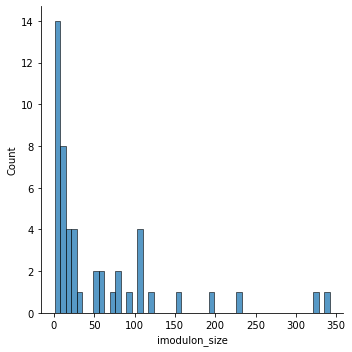

In [77]:
sns.displot(ica_data.imodulon_table['imodulon_size'],bins=50)

In [78]:
ica_data.imodulon_table.shape

(49, 3)

In [79]:
import matplotlib.pyplot as plt

(array([0.24489796, 0.42857143, 0.48979592, 0.53061224, 0.65306122,
        0.65306122, 0.69387755, 0.73469388, 0.7755102 , 0.7755102 ,
        0.7755102 , 0.7755102 , 0.7755102 , 0.81632653, 0.83673469,
        0.85714286, 0.87755102, 0.87755102, 0.91836735, 0.93877551,
        0.93877551, 0.93877551, 0.95918367, 0.95918367, 0.95918367,
        0.95918367, 0.95918367, 0.95918367, 0.97959184, 1.        ]),
 array([0.00218634, 0.00482796, 0.00746958, 0.01011121, 0.01275283,
        0.01539446, 0.01803608, 0.0206777 , 0.02331933, 0.02596095,
        0.02860258, 0.0312442 , 0.03388582, 0.03652745, 0.03916907,
        0.0418107 , 0.04445232, 0.04709394, 0.04973557, 0.05237719,
        0.05501882, 0.05766044, 0.06030206, 0.06294369, 0.06558531,
        0.06822694, 0.07086856, 0.07351018, 0.07615181, 0.07879343,
        0.08143505]),
 <BarContainer object of 30 artists>)

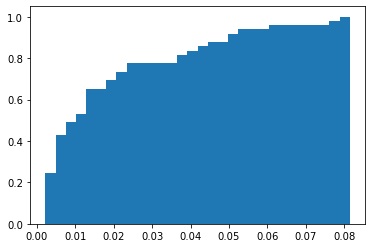

In [80]:
x = ica_data.imodulon_table.sort_values('explained_variance',ascending=False)['explained_variance']
plt.hist(x,cumulative=True, density=True, bins=30)

<AxesSubplot:xlabel='explained_variance', ylabel='Proportion'>

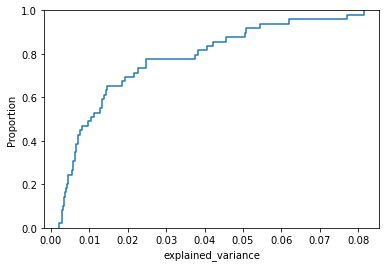

In [81]:
sns.ecdfplot(data=ica_data.imodulon_table, x='explained_variance')

In [82]:
ica_data.imodulon_table.sort_values('explained_variance',ascending=False)

,single_gene,imodulon_size,explained_variance
33,,24.0,0.081435
40,,322.0,0.077054
34,,15.0,0.061954
27,,19.0,0.054464
22,,105.0,0.050861
26,,9.0,0.050407
29,,62.0,0.045652
39,,227.0,0.042088
11,,61.0,0.040583
17,,11.0,0.038322


Text(0, 0.5, 'Explained Variance')

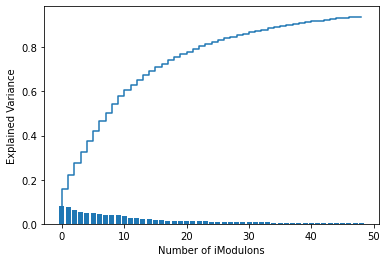

In [83]:
cx = list(zip(*enumerate(np.cumsum(x.values))))
plt.step(cx[0],cx[1])
plt.bar(cx[0],x.values)
plt.xlabel('Number of iModulons')
plt.ylabel('Explained Variance')

In [57]:
cx

[(0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52),
 (0.06900293360178722,
  0.13186566125842847,
  0.1938207054694162,
  0.2554726059283694,
  0.3080275684492726,
  0.35409204936484606,
  0.3987290490468095,
  0.44319499784782534,
  0.483417165737105,
  0.5202758272757787,
  0.5568596401200442,
  0.5881076859878112,
  0.6169245396883143,
  0.6407374863728559,
  0.6632552851749801,
  0.6847728189611688,
  0.7047833053054781,
  0.7235195825889622,
  0.7369543341035725,
  0.7494098392600224,
  0.7610593267152341,
  0.7720206833869259,
  0.7816843772343722,
  0.7910142361951342,
  0.7987969995833955,
  0.8061570808269353,
  0.8132891165357968,
  0.8202750341451914,
  0.8271614487352754,
  0.833821832429998,
  0.8403983604256231,
  0.846

<AxesSubplot:xlabel='imodulon_size', ylabel='explained_variance'>

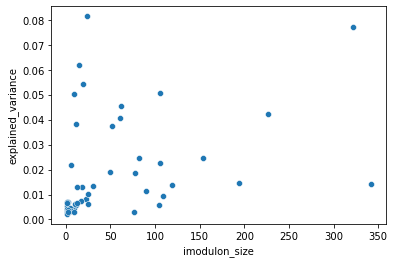

In [84]:
sns.scatterplot(data=ica_data.imodulon_table, x='imodulon_size',y='explained_variance')

In [90]:
import altair as alt

In [85]:
idx=29
ica_data.view_imodulon(idx)[['product','gene_weight','tu_name','gene_name_extra']]

,product,gene_weight,tu_name,gene_name_extra
EQU24_RS00940,hypothetical protein,-0.072191,EQU24_RS00940,||None
EQU24_RS01305,IS66 family transposase,-0.072599,EQU24_RS01305,||None
EQU24_RS02055,TonB-dependent receptor,-0.070473,EQU24_RS02055,||None
EQU24_RS02555,hypothetical protein,0.129413,EQU24_RS02555,||None
EQU24_RS03400,hypothetical protein,0.065638,EQU24_RS03405 // EQU24_RS03400,||
...,...,...,...,...
EQU24_RS17160,nitrogen fixation protein NifX,0.065969,EQU24_RS17160,||None
EQU24_RS17270,nitrogen fixation negative regulator NifL,0.065009,nifA // nifL,nifL||nifL
EQU24_RS17275,nif-specific transcriptional activator NifA,0.056701,nifA // nifL,nifA||nifA
EQU24_RS19155,DUF2182 domain-containing protein,0.065364,EQU24_RS19155,||None


In [86]:
DF_enrichments[DF_enrichments['imodulon']==idx]

,imodulon,go_name,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,source,annotation,pathway_name,module_name
154,29,nitrogen fixation,5.817899e-06,0.023871,0.080645,0.263158,0.123457,5.0,19.0,62.0,GO,NaN,NaN,NaN
20,29,NaN,4.315480e-09,0.000001,0.145161,0.219512,0.174757,9.0,41.0,62.0,KEGG pathways,map00910,Nitrogen metabolism,NaN
21,29,NaN,6.333123e-04,0.080114,0.032258,0.666667,0.061538,2.0,3.0,62.0,KEGG pathways,map00791,Atrazine degradation,NaN
28,29,NaN,3.036741e-06,0.001032,0.048387,1.000000,0.092308,3.0,3.0,62.0,KEGG modules,M00438,NaN,None
29,29,NaN,5.884075e-05,0.010003,0.048387,0.500000,0.088235,3.0,6.0,62.0,KEGG modules,M00530,NaN,"Dissimilatory nitrate reduction, nitrate => am..."


In [87]:
ica_data.imodulon_table[ica_data.imodulon_table.index ==idx]

,single_gene,imodulon_size,explained_variance
29,,62.0,0.045652
